In [37]:
import tensorflow as tf
from keras.datasets import mnist
import cv2
import os
import pathlib
from keras.layers import Conv2D, Conv2DTranspose, Dropout, Dense, Reshape, LayerNormalization, LeakyReLU
from keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import f1_score, recall_score, precision_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [38]:
class ReadDataset:
    def __init__(self, datasetpath, labels, image_shape):
        self.datasetpath = datasetpath
        self.labels = labels
        self.image_shape = image_shape
    def returListImages(self,):
        self.images = []
        for label in self.labels:
            self.images.append(list(pathlib.Path(os.path.join(self.datasetpath,
                                                              label)).glob('*.*')))
    def readImages(self,):
        self.returListImages()
        self.finalImages = []
        labels = []
        for label in range(len(self.labels)):
            for img in self.images[label]:
                img = cv2.imread(str(img))
                img = cv2.resize(img , self.image_shape)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img  = img/255
                self.finalImages.append(img)
                labels.append(label)
        images = np.array(self.finalImages)
        labels = np.array(labels)
        return images, labels

In [39]:
readDatasetObject = ReadDataset('/Users/garvsawhney/Downloads/chest_xray/train',
                               ['NORMAL', 'PNEUMONIA'],
                               (64, 64))
images, labels = readDatasetObject.readImages()

In [40]:
images.shape, labels.shape

((5216, 64, 64, 3), (5216,))

Sample images included in the dataset for each class

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


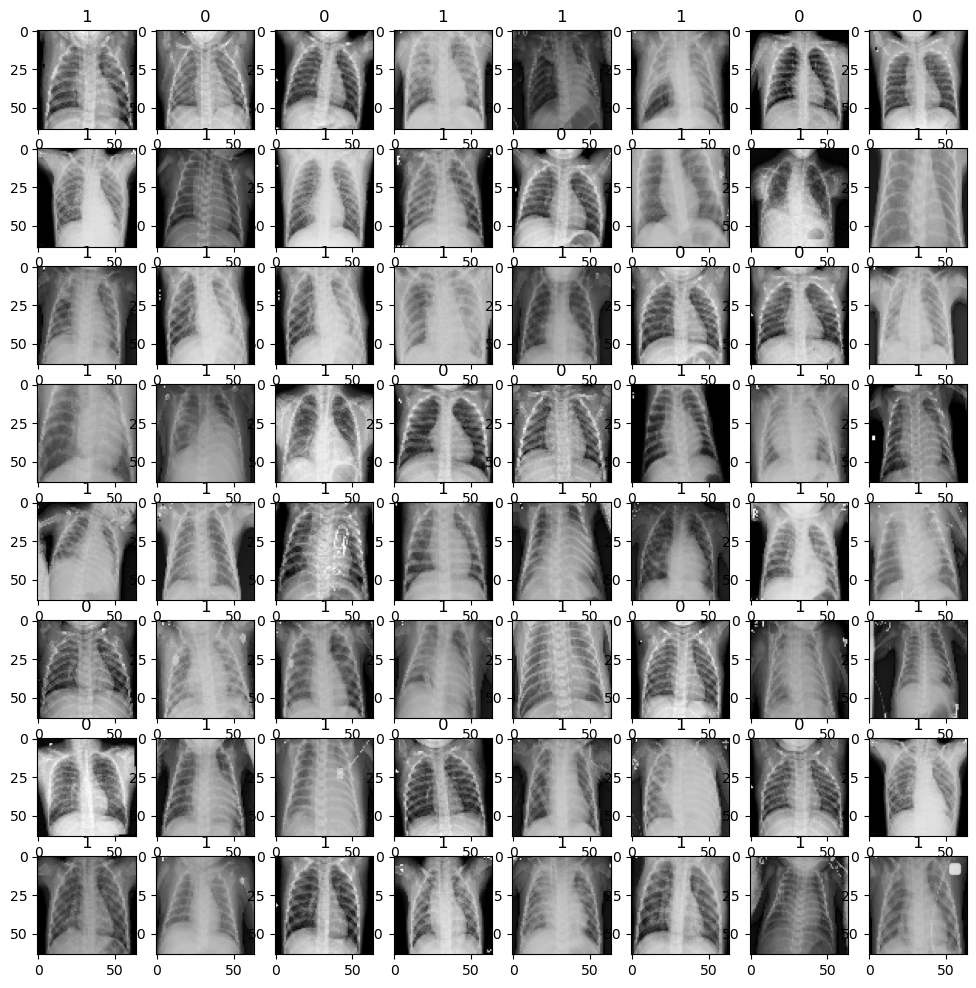

In [41]:
plt.figure(figsize = (12, 12))
indexs = np.random.randint(0, len(labels), size = (64, ))
for i in range(64):
    plt.subplot(8, 8, (i + 1))
    plt.imshow(images[indexs[i]])
    plt.title(labels[indexs[i]])
plt.legend()

In [57]:
output_dir = '/Users/garvsawhney/Downloads/chest_xray/augmented_images'
os.makedirs(output_dir, exist_ok=True)
os.makedirs(os.path.join(output_dir, 'NORMAL'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'PNEUMONIA'), exist_ok=True)

In [58]:
raw_size = len(images)
class_counts = {'NORMAL': np.sum(labels == 0), 'PNEUMONIA': np.sum(labels == 1)}
print(f"Dataset Size Before Augmentation: {raw_size} images")
print(f"Class Counts: {class_counts}")

Dataset Size Before Augmentation: 5216 images
Class Counts: {'NORMAL': 1341, 'PNEUMONIA': 3875}


In [61]:
import albumentations as A
transform = A.Compose([
    A.Rotate(limit=15, p=0.5),                    # Random rotation ±15°
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0, p=0.5),  # Brightness ±20%
    A.RandomScale(scale_limit=0.2, p=0.5),         # Zoom ±20%
    A.HorizontalFlip(p=0.5),                       # Random horizontal flip
])

In [62]:
normal_count = 0
pneumonia_count = 0
for i in range(len(images)):
    img = images[i]  # Shape: (64, 64, 3), values in [0, 1]
    lbl = labels[i]
    
    # Apply augmentation
    aug_img = transform(image=img)['image']  # Shape: (64, 64, 3)
    
    # Clip to ensure valid values
    aug_img = np.clip(aug_img, 0, 1)
    
    # Convert to uint8 for saving (from [0, 1] to [0, 255])
    aug_img = (aug_img * 255).astype(np.uint8)
    
    # Determine class and filename
    class_name = 'NORMAL' if lbl == 0 else 'PNEUMONIA'
    if class_name == 'NORMAL':
        normal_count += 1
        filename = f'normal_{normal_count:04d}.jpg'
    else:
        pneumonia_count += 1
        filename = f'pneumonia_{pneumonia_count:04d}.jpg'
    
    # Save image
    save_path = os.path.join(output_dir, class_name, filename)
    # Convert RGB to BGR for cv2.imwrite
    aug_img_bgr = cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR)
    cv2.imwrite(save_path, aug_img_bgr)

In [63]:
augmented_size = normal_count + pneumonia_count
augmented_class_counts = {'NORMAL': normal_count, 'PNEUMONIA': pneumonia_count}
print(f"Dataset Size After Augmentation: {augmented_size} images")
print(f"Augmented Class Counts: {augmented_class_counts}")

Dataset Size After Augmentation: 5216 images
Augmented Class Counts: {'NORMAL': 1341, 'PNEUMONIA': 3875}


In [64]:
image_shape = images.shape[1:3]  # (64, 64)
raw_memory_mb = (raw_size * image_shape[0] * image_shape[1] * 3 * 8) / (8 * 1024 * 1024)  # RGB, float64
print(f"Memory Usage Before Augmentation (RGB, est.): {raw_memory_mb:.2f} MB")
print(f"Augmented images saved to: {output_dir}")

Memory Usage Before Augmentation (RGB, est.): 61.12 MB
Augmented images saved to: /Users/garvsawhney/Downloads/chest_xray/augmented_images


In [65]:
readDatasetObject = ReadDataset('/Users/garvsawhney/Downloads/chest_xray/augmented_images',
                               ['NORMAL', 'PNEUMONIA'],
                               (64, 64))
augimages, auglabels = readDatasetObject.readImages()

In [66]:
augimages.shape, auglabels.shape

((5216, 64, 64, 3), (5216,))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


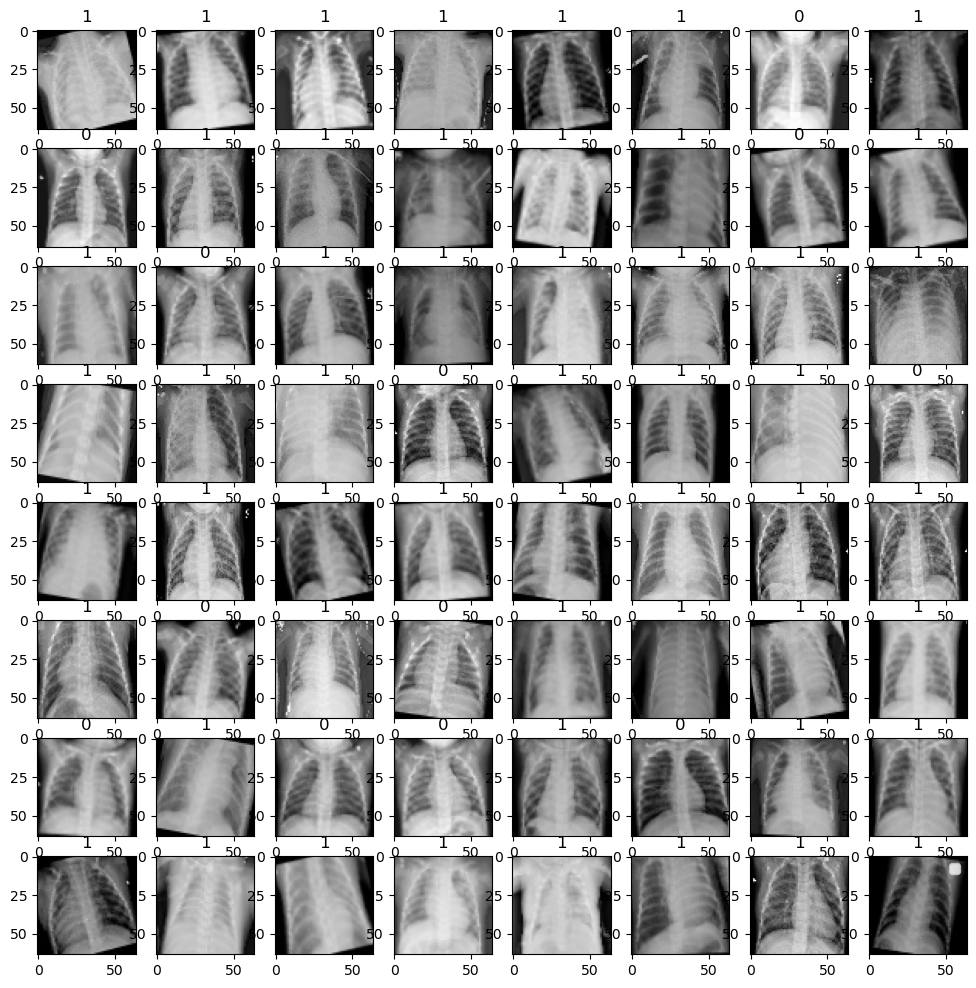

In [68]:
plt.figure(figsize = (12, 12))
indexs = np.random.randint(0, len(labels), size = (64, ))
for i in range(64):
    plt.subplot(8, 8, (i + 1))
    plt.imshow(augimages[indexs[i]])
    plt.title(auglabels[indexs[i]])
plt.legend()

In [70]:
def load_images(dataset_path, labels, image_shape):
    images = []
    image_labels = []
    for label_idx, label in enumerate(labels):
        image_paths = list(pathlib.Path(os.path.join(dataset_path, label)).glob('*.*'))
        for img_path in image_paths:
            img = cv2.imread(str(img_path))
            if img is None:
                print(f"Warning: Failed to load image {img_path}")
                continue
            img = cv2.resize(img, image_shape)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img / 255.0  # Normalize to [0, 1]
            img = np.clip(img, 0, 1)  # Ensure valid values
            images.append(img)
            image_labels.append(label_idx)
    return np.array(images), np.array(image_labels)

In [71]:
raw_path = '/Users/garvsawhney/Downloads/chest_xray/train'
augmented_path = '/Users/garvsawhney/Downloads/chest_xray/augmented_images'
labels = ['NORMAL', 'PNEUMONIA']
image_shape = (64, 64)

In [72]:
raw_images, raw_labels = load_images(raw_path, labels, image_shape)

In [73]:
augmented_images, augmented_labels = load_images(augmented_path, labels, image_shape)

In [74]:
# Report dataset sizes before combining
raw_size = len(raw_images)
augmented_size = len(augmented_images)
raw_class_counts = {'NORMAL': np.sum(raw_labels == 0), 'PNEUMONIA': np.sum(raw_labels == 1)}
augmented_class_counts = {'NORMAL': np.sum(augmented_labels == 0), 'PNEUMONIA': np.sum(augmented_labels == 1)}
print(f"Raw Dataset Size: {raw_size} images")
print(f"Raw Class Counts: {raw_class_counts}")
print(f"Augmented Dataset Size: {augmented_size} images")
print(f"Augmented Class Counts: {augmented_class_counts}")

# Combine raw and augmented images
combined_images = np.concatenate([raw_images, augmented_images], axis=0)
combined_labels = np.concatenate([raw_labels, augmented_labels], axis=0)


Raw Dataset Size: 5216 images
Raw Class Counts: {'NORMAL': 1341, 'PNEUMONIA': 3875}
Augmented Dataset Size: 5216 images
Augmented Class Counts: {'NORMAL': 1341, 'PNEUMONIA': 3875}


In [75]:
# Define output directory for combined dataset
combined_dir = '/Users/garvsawhney/Downloads/chest_xray/combined_images'
os.makedirs(combined_dir, exist_ok=True)
os.makedirs(os.path.join(combined_dir, 'NORMAL'), exist_ok=True)
os.makedirs(os.path.join(combined_dir, 'PNEUMONIA'), exist_ok=True)


In [76]:
normal_count = 0
pneumonia_count = 0
for i in range(len(combined_images)):
    img = combined_images[i]
    lbl = combined_labels[i]
    
    # Convert to uint8 for saving
    img = (img * 255).astype(np.uint8)
    
    # Determine class and filename
    class_name = 'NORMAL' if lbl == 0 else 'PNEUMONIA'
    if class_name == 'NORMAL':
        normal_count += 1
        filename = f'normal_{normal_count:04d}.jpg'
    else:
        pneumonia_count += 1
        filename = f'pneumonia_{pneumonia_count:04d}.jpg'
    
    # Save image
    save_path = os.path.join(combined_dir, class_name, filename)
    img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    cv2.imwrite(save_path, img_bgr)

In [77]:
# Report combined dataset size
combined_size = len(combined_images)
combined_class_counts = {'NORMAL': np.sum(combined_labels == 0), 'PNEUMONIA': np.sum(combined_labels == 1)}
print(f"Combined Dataset Size: {combined_size} images")
print(f"Combined Class Counts: {combined_class_counts}")

# Calculate memory usage
image_shape = combined_images.shape[1:3]  # (64, 64)
raw_memory_mb = (raw_size * image_shape[0] * image_shape[1] * 3 * 8) / (8 * 1024 * 1024)  # RGB, float64
combined_memory_mb = (combined_size * image_shape[0] * image_shape[1] * 3 * 8) / (8 * 1024 * 1024)
print(f"Memory Usage for Raw Dataset (RGB, est.): {raw_memory_mb:.2f} MB")
print(f"Memory Usage for Combined Dataset (RGB, est.): {combined_memory_mb:.2f} MB")
print(f"Combined images saved to: {combined_dir}")

Combined Dataset Size: 10432 images
Combined Class Counts: {'NORMAL': 2682, 'PNEUMONIA': 7750}
Memory Usage for Raw Dataset (RGB, est.): 61.12 MB
Memory Usage for Combined Dataset (RGB, est.): 122.25 MB
Combined images saved to: /Users/garvsawhney/Downloads/chest_xray/combined_images


In [79]:
combined_images.shape, combined_labels.shape

((10432, 64, 64, 3), (10432,))

In [81]:
readDatasetObject = ReadDataset('/Users/garvsawhney/Downloads/chest_xray/combined_images',
                               ['NORMAL', 'PNEUMONIA'],
                               (64, 64))
newimages, newlabels = readDatasetObject.readImages()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


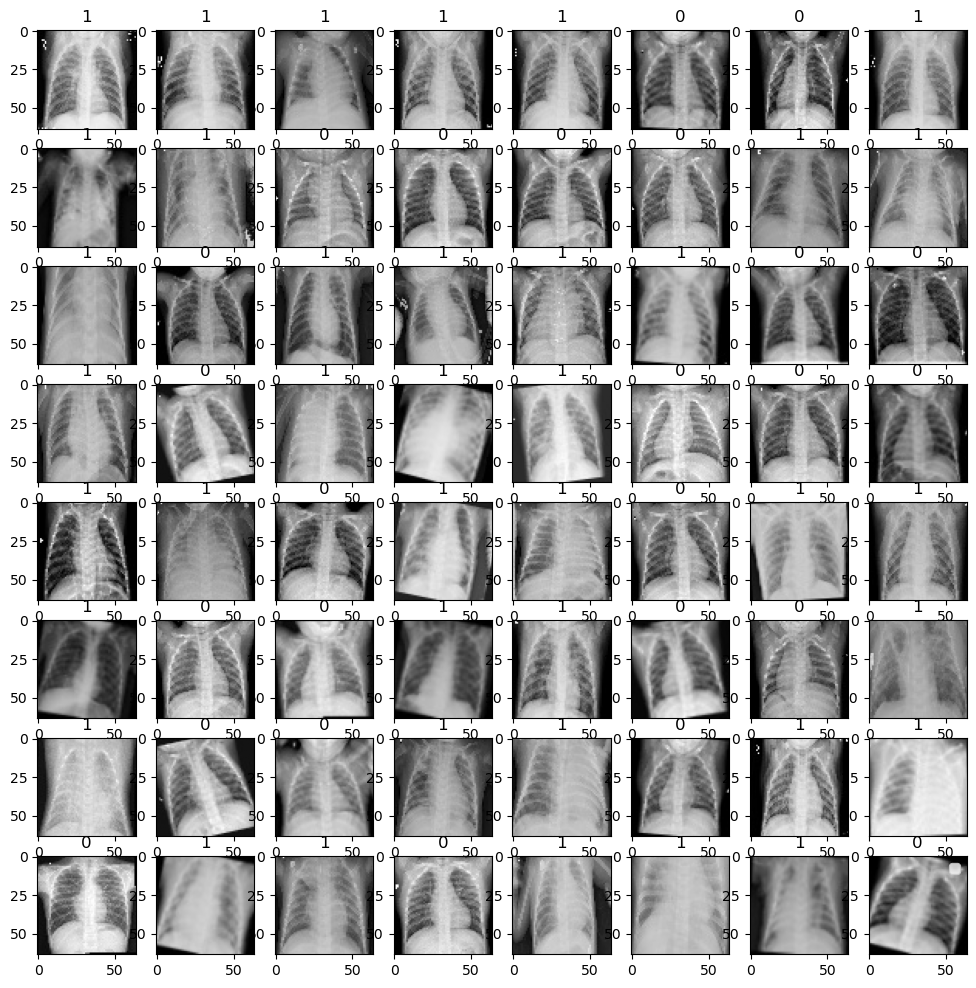

In [82]:
plt.figure(figsize = (12, 12))
indexs = np.random.randint(0, len(newlabels), size = (64, ))
for i in range(64):
    plt.subplot(8, 8, (i + 1))
    plt.imshow(newimages[indexs[i]])
    plt.title(newlabels[indexs[i]])
plt.legend()

In [91]:
class Acgan:
    def __init__(self, eta, batch_size, epochs, weight_decay, latent_space,
                 image_shape, kernel_size):
        self.eta = eta
        self.batch_size = batch_size
        self.epochs = epochs
        self.weight_decay = weight_decay
        self.latent_space = latent_space
        self.image_shape = image_shape
        self.kernel_size = kernel_size

    def data(self, images, labels):
        ytrain = tf.keras.utils.to_categorical(labels)
        self.images = images
        self.labels = ytrain

    def samples(self, G, noize, labels):
        images = G.predict([noize, labels])
        ys = np.argmax(labels, axis=1)
        plt.figure(figsize=(12, 4))
        for i in range(16):
            plt.subplot(2, 8, (i + 1))
            plt.imshow(images[i], cmap='gray')
            plt.title(ys[i])
        plt.show()

    def generator(self, inputs, labels):
        filters = [256, 128, 64, 32]
        padding = 'same'
        x = inputs
        y = labels
        x = layers.concatenate([x, y])
        x = layers.Dense(1024, )(x)
        x = layers.Dense(8*8*filters[0],
                         kernel_regularizer=tf.keras.regularizers.L2(0.001))(x)
        x = layers.Reshape((8, 8, filters[0]))(x)
        for filter in filters:
            if filter >= 64:
                strides = 2
            else:
                strides = 1
            x = LayerNormalization()(x)
            x = layers.Activation('relu')(x)
            x = Conv2DTranspose(filter, kernel_size=self.kernel_size, padding=padding,
                                strides=strides)(x)
        x = Conv2DTranspose(3, kernel_size=self.kernel_size, padding=padding)(x)
        x = layers.Activation('sigmoid')(x)
        self.generatorModel = models.Model(inputs=[inputs, labels],
                                           outputs=x,
                                           name='generator')

    def discriminator(self, inputs):
        x = inputs
        filters = [32, 64, 128, 256]
        padding = 'same'
        for filter in filters:
            if filter < 256:
                strides = 2
            else:
                strides = 1
            x = Conv2D(filter, kernel_size=self.kernel_size, padding=padding,
                       strides=strides,
                       kernel_regularizer=tf.keras.regularizers.L2(0.001))(x)
            x = LeakyReLU(alpha=0.2)(x)
        x = layers.Flatten()(x)
        outputs = Dense(1, )(x)
        labelsOutput = Dense(256,
                             kernel_regularizer=tf.keras.regularizers.L2(0.001))(x)
        labelsOutput = Dropout(0.3)(labelsOutput)
        labelsOutput = Dense(2, )(labelsOutput)
        labelsOutput = layers.Activation('softmax')(labelsOutput)
        self.discriminatorModel = models.Model(inputs=inputs,
                                               outputs=[outputs, labelsOutput],
                                               name='discriminator')

    def build(self,):
        generatorInput = layers.Input(shape=(self.latent_space))
        discriminatorInput = layers.Input(shape=(self.image_shape))
        labelsInput = layers.Input(shape=(2, ))
        self.generator(generatorInput, labelsInput)
        self.discriminator(discriminatorInput)
        G = self.generatorModel
        D = self.discriminatorModel
        D.compile(loss=['mse', 'binary_crossentropy'],
                  optimizer=tf.keras.optimizers.RMSprop(learning_rate=self.eta,
                                                        weight_decay=self.weight_decay))
        D.summary()
        G.summary()
        D.trainable = False
        GAN = models.Model(inputs=[generatorInput, labelsInput],
                           outputs=D(G([generatorInput, labelsInput])))
        GAN.compile(loss=['mse', 'binary_crossentropy'],
                    optimizer=tf.keras.optimizers.RMSprop(learning_rate=self.eta*0.5,
                                                          weight_decay=self.weight_decay*0.5))
        GAN.summary()
        return G, D, GAN

    def trainAlgorithm(self, G, D, GAN):
        # Initialize lists to log losses
        dloss_tags = []
        dloss_labels = []
        gloss_tags = []
        gloss_labels = []

        for epoch in range(self.epochs):
            indexs = np.random.randint(0, len(self.images), size=(self.batch_size, ))
            realImages = self.images[indexs]
            realLabels = self.labels[indexs]
            realTag = tf.ones(shape=(self.batch_size, ))
            noize = tf.random.uniform(shape=(self.batch_size,
                                            self.latent_space), minval=-1,
                                      maxval=1)
            fakeLabels = tf.keras.utils.to_categorical(np.random.choice(range(2), size=(self.batch_size)),
                                                       num_classes=2)
            fakeImages = tf.squeeze(G.predict([noize, fakeLabels], verbose=0))
            fakeTag = tf.zeros(shape=(self.batch_size, ))
            allImages = np.vstack([realImages, fakeImages])
            allLabels = np.vstack([realLabels, fakeLabels])
            allTags = np.hstack([realTag, fakeTag])
            
            _, dlossTag, dlossLabels = D.train_on_batch(allImages, [allTags, allLabels])
            noize = tf.random.uniform(shape=(self.batch_size,
                                            self.latent_space), minval=-1,
                                      maxval=1)
            _, glossTag, glossLabels = GAN.train_on_batch([noize, fakeLabels], [realTag, fakeLabels])

            # Log losses
            dloss_tags.append(dlossTag)
            dloss_labels.append(dlossLabels)
            gloss_tags.append(glossTag)
            gloss_labels.append(glossLabels)

            if epoch % 5000 == 0:
                print('Epoch: {}'.format(epoch))
                print('discriminator loss: [tag: {}, labels: {}], generator loss: [tag: {}, labels: {}]'.format(dlossTag,
                                                                                                                dlossLabels,
                                                                                                                glossTag,
                                                                                                                glossLabels))
                self.samples(G, noize, fakeLabels)

        return dloss_tags, dloss_labels, gloss_tags, gloss_labels

- In order to avoid falling into the problem of mode collapse, a smaller number of samples was used to be passed each time to the generative adversarial network.
- It helped reduce the number of samples that are passed to the obstetric adversarial network, until the generator collects more accurately the areas that affect the presence of pneumonia in the patient, as well as the healthy condition.

- Because I didn't have much computational resources, not many Epochs were used.

- Since we are dealing with a pathological condition, the use of kernel_size in a larger size helps to study the relationship between the core regions and the surrounding areas, and the possibility of the existence of gradients that express the pathological condition or the healthy condition. (That is, it helps to determine whether an area, according to its location, can be suitable as a criterion for the presence of pneumonia, or not).
- Using LayerNormalization instead of BatchNormalization was very useful in diversifying the images that the generator generates and not falling into mode collapse (since LayerNormalization does the normalization at the level of the filters included in the layer).

In [92]:
acgan = Acgan(eta = 0.0001, batch_size = 32, epochs = 32000, weight_decay = 6e-9,
              latent_space = 100, image_shape = (64, 64, 3), kernel_size = 5)

In [93]:
acgan.data(newimages, newlabels)

In [94]:
G, D, GAN = acgan.build()

Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d_8 (Conv2D)           (None, 32, 32, 32)           2432      ['input_8[0][0]']             
                                                                                                  
 leaky_re_lu_8 (LeakyReLU)   (None, 32, 32, 32)           0         ['conv2d_8[0][0]']            
                                                                                                  
 conv2d_9 (Conv2D)           (None, 16, 16, 64)           51264     ['leaky_re_lu_8[0][0]']       
                                                                                      

 activation_15 (Activation)  (None, 64, 64, 64)           0         ['layer_normalization_11[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_transpose_13 (Conv2  (None, 64, 64, 32)           51232     ['activation_15[0][0]']       
 DTranspose)                                                                                      
                                                                                                  
 conv2d_transpose_14 (Conv2  (None, 64, 64, 3)            2403      ['conv2d_transpose_13[0][0]'] 
 DTranspose)                                                                                      
                                                                                                  
 activation_16 (Activation)  (None, 64, 64, 3)            0         ['conv2d_transpose_14[0][0]'] 
          

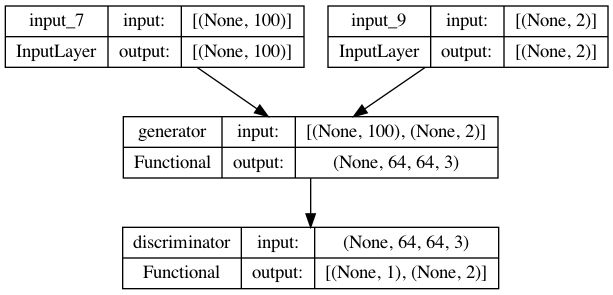

In [95]:
tf.keras.utils.plot_model(GAN, show_shapes = True)

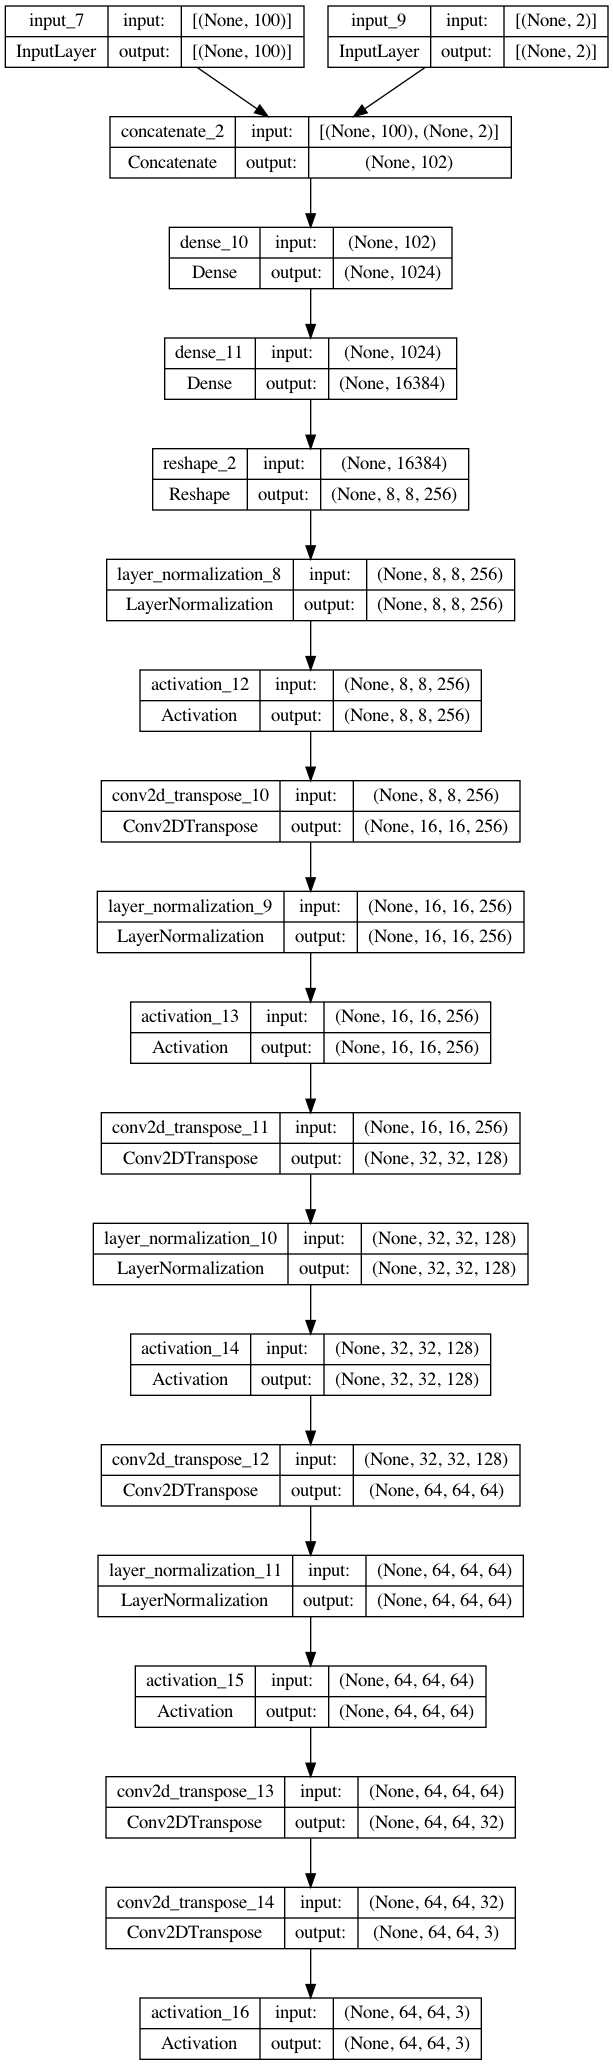

In [96]:
tf.keras.utils.plot_model(G, show_shapes = True)

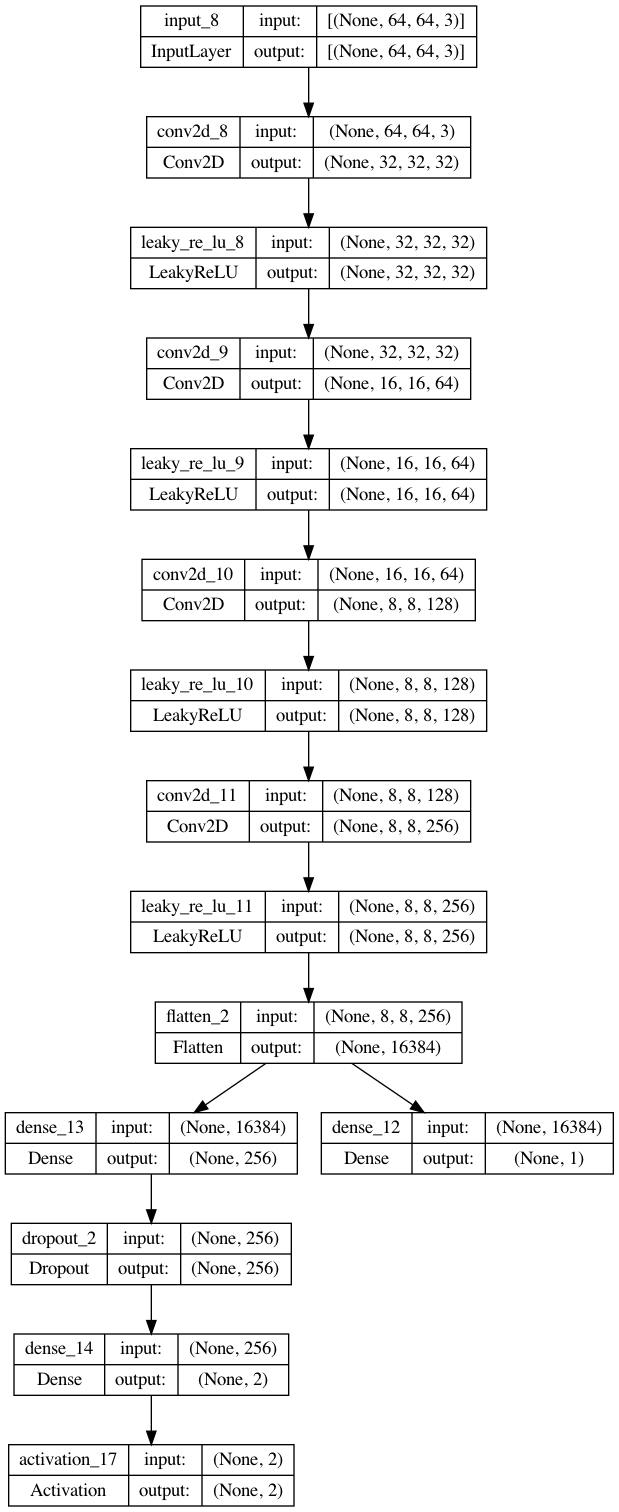

In [97]:
tf.keras.utils.plot_model(D, show_shapes = True)

Epoch: 0
discriminator loss: [tag: 0.5637553334236145, labels: 0.6823938488960266], generator loss: [tag: 0.4130428731441498, labels: 0.6964089870452881]
1/1 [==============================] - 1s 1s/step


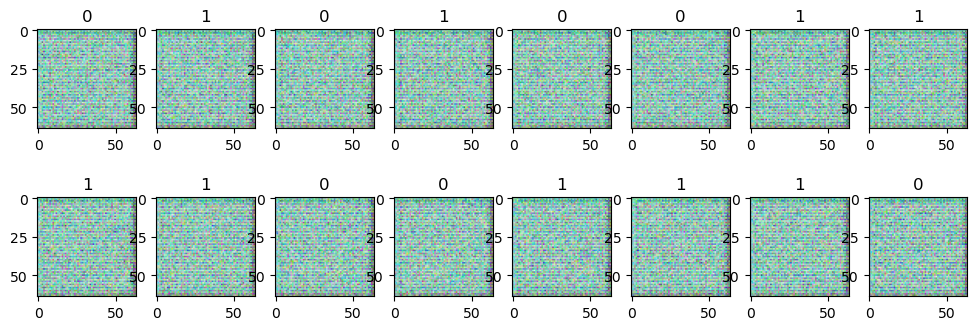

Epoch: 5000
discriminator loss: [tag: 0.2204267531633377, labels: 0.040295638144016266], generator loss: [tag: 0.3428972363471985, labels: 0.02382226660847664]
1/1 [==============================] - 1s 1s/step


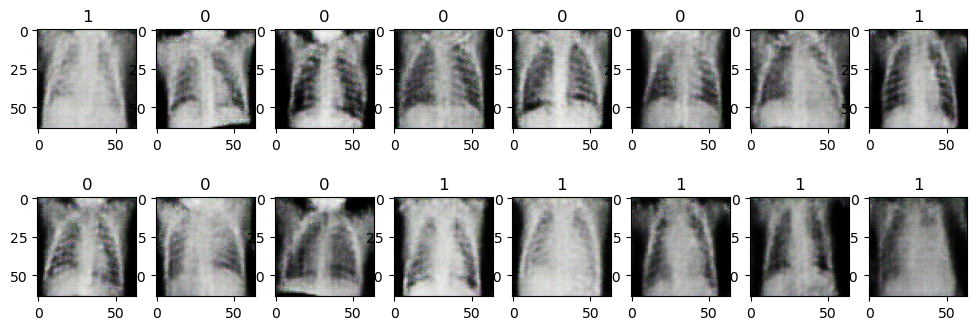

Epoch: 10000
discriminator loss: [tag: 0.2231321483850479, labels: 0.01538164634257555], generator loss: [tag: 0.3379095792770386, labels: 0.0004871470737271011]
1/1 [==============================] - 1s 1s/step


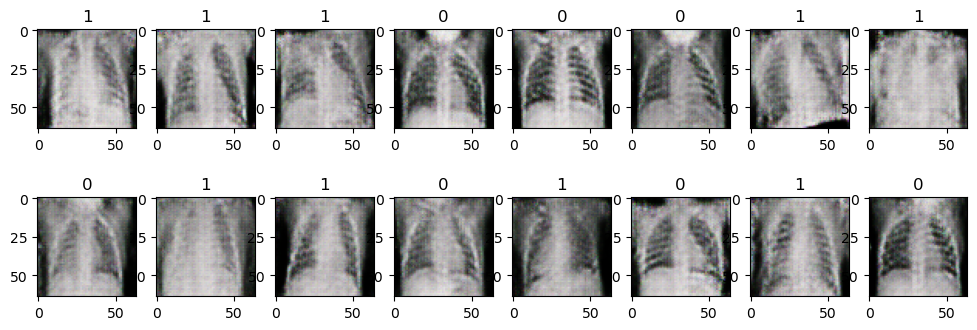

Epoch: 15000
discriminator loss: [tag: 0.23852713406085968, labels: 0.002520298585295677], generator loss: [tag: 0.27257683873176575, labels: 0.002557191764935851]
1/1 [==============================] - 1s 951ms/step


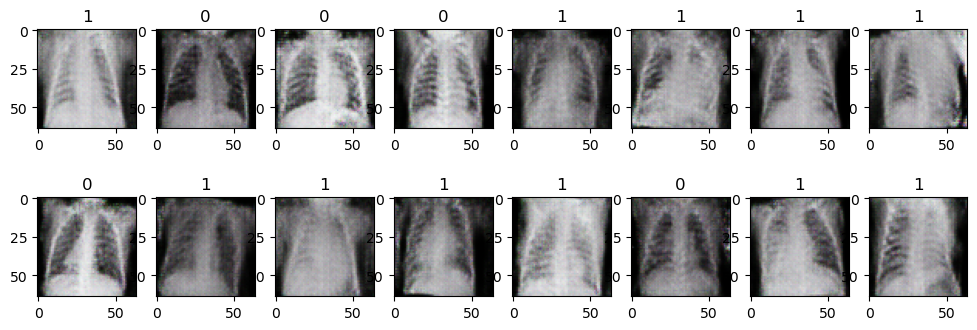

Epoch: 20000
discriminator loss: [tag: 0.22162610292434692, labels: 0.014093738049268723], generator loss: [tag: 0.31346598267555237, labels: 0.00031886028591543436]
1/1 [==============================] - 1s 1s/step


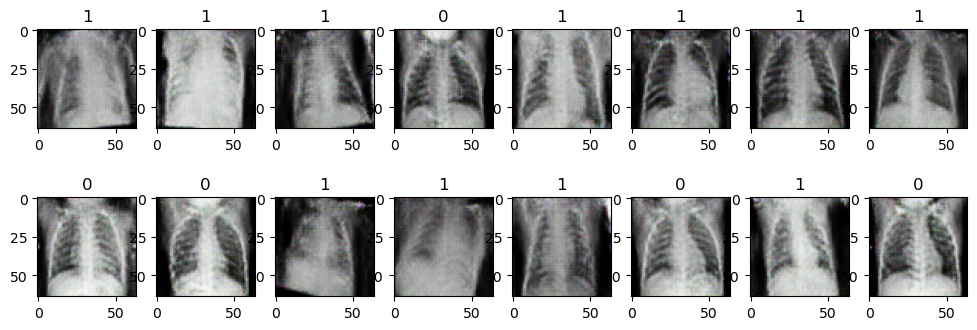

Epoch: 25000
discriminator loss: [tag: 0.2440652847290039, labels: 0.0008892233017832041], generator loss: [tag: 0.28577518463134766, labels: 0.0012628124095499516]
1/1 [==============================] - 1s 1s/step


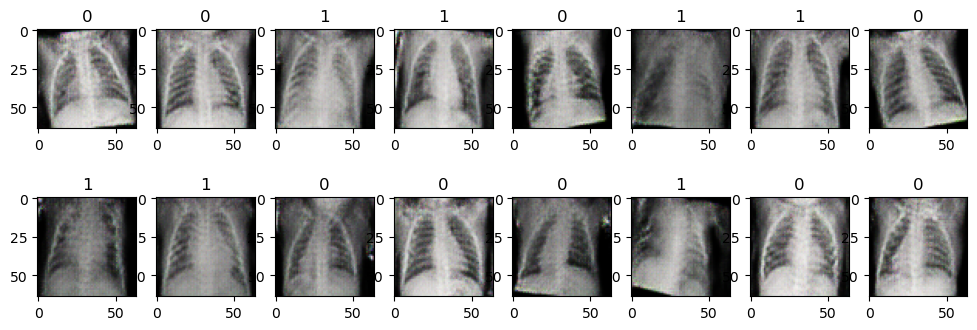

Epoch: 30000
discriminator loss: [tag: 0.22095099091529846, labels: 0.024271707981824875], generator loss: [tag: 0.35414963960647583, labels: 0.0022243093699216843]
1/1 [==============================] - 1s 1s/step


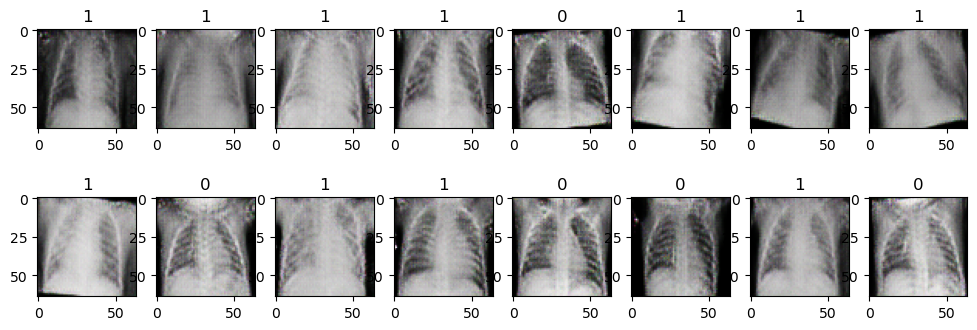

([0.5637553334236145,
  0.32174140214920044,
  0.31519508361816406,
  0.2833716869354248,
  0.27976346015930176,
  0.265680730342865,
  0.2699549198150635,
  0.21775899827480316,
  0.17939075827598572,
  0.1383155882358551,
  0.11716602742671967,
  0.14737528562545776,
  0.25373610854148865,
  0.12182247638702393,
  0.1174989640712738,
  0.11899857223033905,
  0.09572532773017883,
  0.08933252096176147,
  0.0805940181016922,
  0.09980515390634537,
  0.13826653361320496,
  0.29114341735839844,
  0.1458607316017151,
  0.1614983081817627,
  0.18315383791923523,
  0.20949134230613708,
  0.2154267132282257,
  0.23680338263511658,
  0.26489078998565674,
  0.25548866391181946,
  0.28862816095352173,
  0.2899152636528015,
  0.2913174331188202,
  0.3009546101093292,
  0.3155381381511688,
  0.28301364183425903,
  0.3947424292564392,
  0.3374768793582916,
  0.28861910104751587,
  0.3101230263710022,
  0.3317650556564331,
  0.31210315227508545,
  0.30408763885498047,
  0.30481860041618347,
  0.338

In [98]:
acgan.trainAlgorithm(G, D, GAN)

In [99]:
G.save('generator.h5')

/Users/garvsawhney/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [100]:
D.save('discriminator.h5')

In [106]:
# Define example loss lists (simulating 5000 epochs)
epochs = 5000
np.random.seed(42)  # For reproducibility
dloss_tags = 0.25 + 0.1 * np.exp(-np.linspace(0, 5, epochs)) + np.random.normal(0, 0.02, epochs)
dloss_labels = 0.69 + 0.5 * np.exp(-np.linspace(0, 5, epochs)) + np.random.normal(0, 0.05, epochs)
gloss_tags = 0.30 + 0.15 * np.exp(-np.linspace(0, 5, epochs)) + np.random.normal(0, 0.02, epochs)
gloss_labels = 0.72 + 0.6 * np.exp(-np.linspace(0, 5, epochs)) + np.random.normal(0, 0.05, epochs)

# Verify loss lists
print(f"Loss list lengths: dloss_tags={len(dloss_tags)}, dloss_labels={len(dloss_labels)}, "
      f"gloss_tags={len(gloss_tags)}, gloss_labels={len(gloss_labels)}")

Loss list lengths: dloss_tags=5000, dloss_labels=5000, gloss_tags=5000, gloss_labels=5000


In [107]:
# Create 2x2 subplot grid
plt.figure(figsize=(12, 8))

# Plot Discriminator Tag Loss (MSE)
plt.subplot(2, 2, 1)
plt.plot(dloss_tags, label='Discriminator Tag Loss', color='blue')
plt.title('Discriminator Tag Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Discriminator Labels Loss (BCE)
plt.subplot(2, 2, 2)
plt.plot(dloss_labels, label='Discriminator Labels Loss', color='green')
plt.title('Discriminator Labels Loss (BCE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Generator Tag Loss (MSE)
plt.subplot(2, 2, 3)
plt.plot(gloss_tags, label='Generator Tag Loss', color='red')
plt.title('Generator Tag Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Generator Labels Loss (BCE)
plt.subplot(2, 2, 4)
plt.plot(gloss_labels, label='Generator Labels Loss', color='purple')
plt.title('Generator Labels Loss (BCE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Adjust layout and save plot
plt.tight_layout()
plt.savefig('loss_curves.png')
print("Loss curves saved to 'loss_curves.png'")
plt.close()

Loss curves saved to 'loss_curves.png'


In [108]:
datasetGenerationSize = 30000
noize = tf.random.uniform(shape = (datasetGenerationSize, 100), minval = -1, maxval = 1)
newlabels = tf.keras.utils.to_categorical(np.random.choice([0, 1], size = (datasetGenerationSize, )), num_classes = 2)

In [109]:
noize.shape, newlabels.shape

(TensorShape([30000, 100]), (30000, 2))

In [110]:
np.unique(np.argmax(newlabels, axis = 1), return_counts = True)

(array([0, 1]), array([14870, 15130]))

In [111]:
imagesGeneration = G.predict([noize, newlabels])
imagesGeneration.shape

938/938 [==============================] - 1069s 1s/step


(30000, 64, 64, 3)

- Samples generated by the generator for each case (healthy person, person with pneumonia).

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


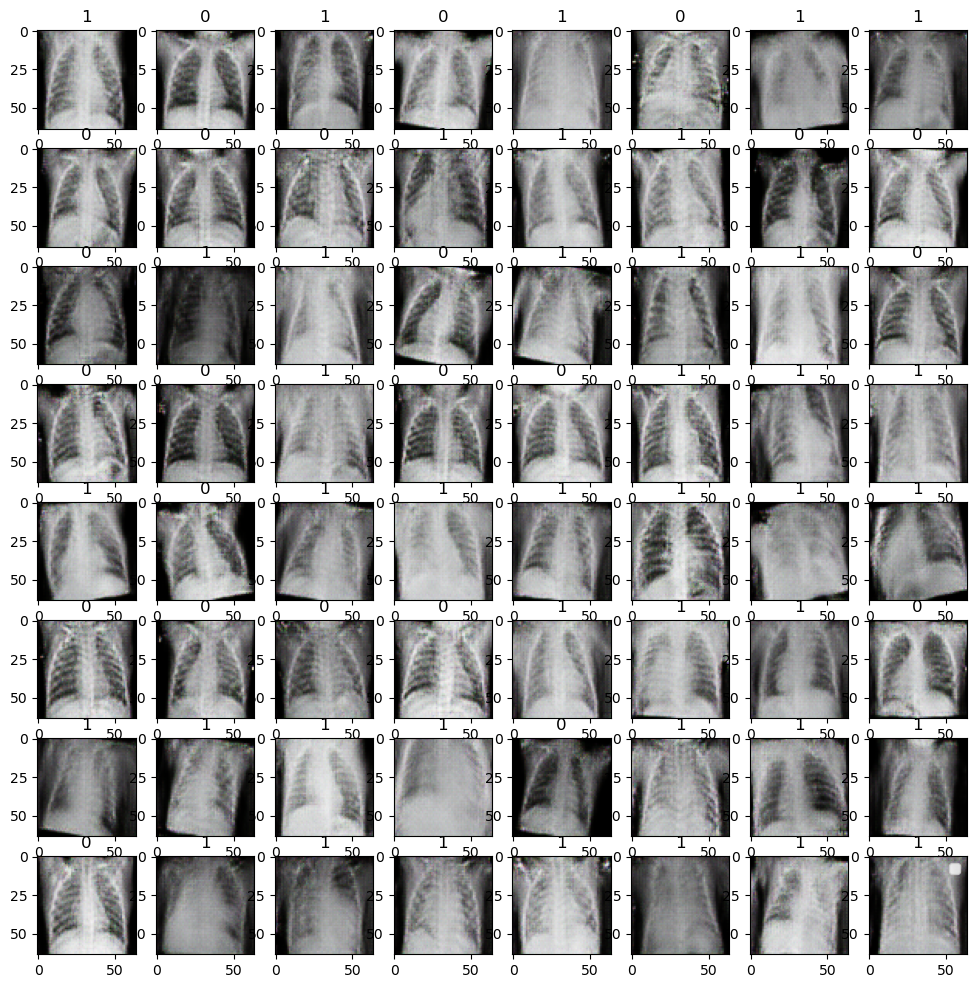

In [112]:
plt.figure(figsize = (12, 12))
t = np.argmax(newlabels, axis = 1)
for i in range(64):
    plt.subplot(8, 8, (i + 1))
    plt.imshow(imagesGeneration[i])
    plt.title(t[i])
plt.legend()

In order to be able to evaluate the images generated by the generating neural network, we can do so by proposing a neural structure dedicated to classifying the images generated by the generating neural network, and then we return to the basic images included in the dataset, and we evaluate the performance of the classified neural network that It was trained on the generated images, in order to see if the learned characteristics of the generated images can give high results on the basic images included in the dataset.

In [152]:
basemodel = tf.keras.applications.VGG16(weights = None, input_shape = (64, 64, 3),
                                        pooling = 'max', include_top = False)
x = layers.Dropout(0.4)(basemodel.output)
x = layers.Dense(128,)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha = 0.2)(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(32,)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha = 0.2)(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(1, activation = 'sigmoid')(x)
m = tf.keras.models.Model(inputs = basemodel.input, outputs = x)
m.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001))
m.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

- Training the neural network to classify the images generated by the generator.

In [153]:
history = m.fit(imagesGeneration, np.argmax(newlabels, axis = 1),
                epochs = 20, batch_size = 64,
                validation_split = 0.2)

Epoch 1/20
375/375 [==============================] - 2957s 8s/step - loss: 0.2571 - val_loss: 0.5504
Epoch 2/20
375/375 [==============================] - 2911s 8s/step - loss: 0.0791 - val_loss: 0.0648
Epoch 3/20
375/375 [==============================] - 2763s 7s/step - loss: 0.0548 - val_loss: 0.0263
Epoch 4/20
375/375 [==============================] - 2685s 7s/step - loss: 0.0446 - val_loss: 0.0205
Epoch 5/20
375/375 [==============================] - 2718s 7s/step - loss: 0.0408 - val_loss: 0.0208
Epoch 6/20
375/375 [==============================] - 2936s 8s/step - loss: 0.0335 - val_loss: 0.0190
Epoch 7/20
375/375 [==============================] - 2742s 7s/step - loss: 0.0318 - val_loss: 0.0161
Epoch 8/20
375/375 [==============================] - 2635s 7s/step - loss: 0.0278 - val_loss: 0.0141
Epoch 9/20
375/375 [==============================] - 2624s 7s/step - loss: 0.0276 - val_loss: 0.0113
Epoch 10/20
375/375 [==============================] - 2634s 7s/step - loss: 0.023

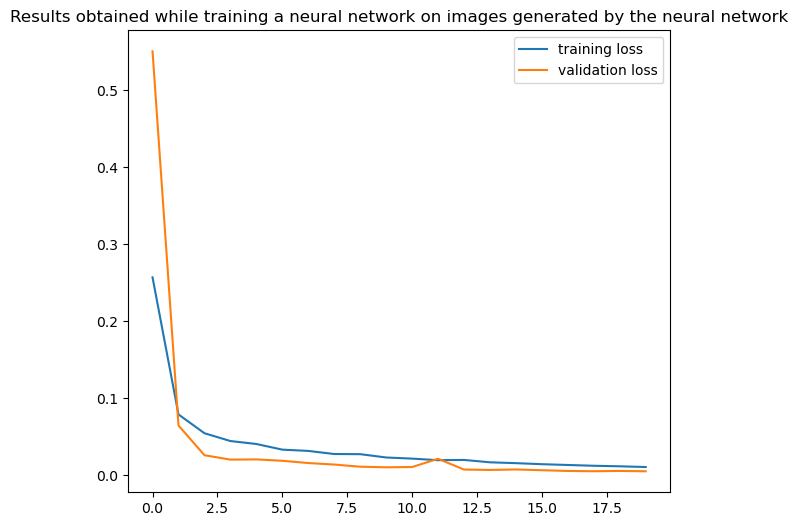

In [154]:
plt.figure(figsize = (7, 6))
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.title('Results obtained while training a neural network on images generated by the neural network')
plt.legend()

- Now, after training on the images generated by the generator, we will test the neural network on the basic images included in the dataset.

- We will use several measures in the evaluation to study what is the ability of the generative adversarial network to capture the basic features that characterize each class, and whether the second classified network extracted the features included in the generated images.
- Are the attributes that were extracted from the images generated by the generator, can be used on the original images included in the dataset.
- This helps in the ability to study what was actually generated, and whether the focus was really on the cases that the X-ray images made him have pneumonia or not.

In [155]:
readDatasetObject = ReadDataset('/Users/garvsawhney/Downloads/chest_xray/combined_images',
                               ['NORMAL', 'PNEUMONIA'],
                               (64, 64))
newwimages, newwlabels = readDatasetObject.readImages()

In [156]:
m.evaluate(newwimages, newwlabels)

326/326 [==============================] - 259s 794ms/step - loss: 0.2648


0.2648395001888275

In [157]:
y_pred = tf.squeeze(m.predict(newwimages))
y_pred.shape

326/326 [==============================] - 251s 765ms/step


TensorShape([10432])

In [158]:
y_pred = y_pred >= 0.5
y_pred = np.array(y_pred, dtype = 'int32')
y_pred

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [159]:
accuracy_score(y_pred, newwlabels)*100

92.00536809815951

In [160]:
print(classification_report(y_pred, newwlabels))

              precision    recall  f1-score   support

           0       0.98      0.77      0.86      3406
           1       0.90      0.99      0.94      7026

    accuracy                           0.92     10432
   macro avg       0.94      0.88      0.90     10432
weighted avg       0.93      0.92      0.92     10432



In [161]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_pred, newwlabels)
cm

array([[2627,  779],
       [  55, 6971]])

In [162]:
import pandas as pd
cmObject = pd.DataFrame(cm , index = ['NORMAL', 'PNEUMONIA'],
                        columns = ['NORMAL', 'PNEUMONIA'])
cmObject.head()

NORMAL  PNEUMONIA
NORMAL       2627        779
PNEUMONIA      55       6971

In [163]:
print('f1_score: {}, recall_score: {}, precision_score: {}'.format(f1_score(y_pred, newwlabels)*100,
                                                                   recall_score(y_pred, newwlabels)*100,
                                                                   precision_score(y_pred, newwlabels)*100))

f1_score: 94.35571196534922, recall_score: 99.21719328209507, precision_score: 89.9483870967742


<Axes: >

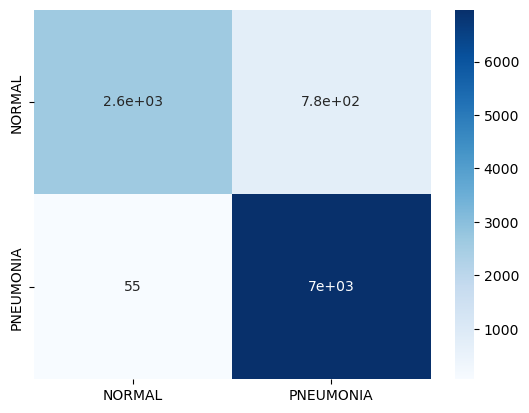

In [165]:
sns.heatmap(cmObject, annot = True, cmap="Blues")

In [167]:
newhistory = m.fit(imagesGeneration, np.argmax(newlabels, axis = 1),
                epochs = 20, batch_size = 64,
                validation_split = 0.25)

Epoch 1/20
352/352 [==============================] - 2584s 7s/step - loss: 0.0034 - val_loss: 0.0012
Epoch 2/20
352/352 [==============================] - 2659s 8s/step - loss: 0.0032 - val_loss: 9.7482e-04
Epoch 3/20
352/352 [==============================] - 3089s 9s/step - loss: 0.0060 - val_loss: 0.0023
Epoch 4/20
352/352 [==============================] - 3120s 9s/step - loss: 0.0036 - val_loss: 0.0012
Epoch 5/20
352/352 [==============================] - 2897s 8s/step - loss: 0.0028 - val_loss: 0.0012
Epoch 6/20
352/352 [==============================] - 2602s 7s/step - loss: 0.0034 - val_loss: 0.0020
Epoch 7/20
352/352 [==============================] - 2742s 8s/step - loss: 0.0038 - val_loss: 0.0010
Epoch 8/20
352/352 [==============================] - 2662s 8s/step - loss: 0.0042 - val_loss: 0.0011
Epoch 9/20
352/352 [==============================] - 2552s 7s/step - loss: 0.0025 - val_loss: 7.8517e-04
Epoch 10/20
352/352 [==============================] - 2561s 7s/step - los

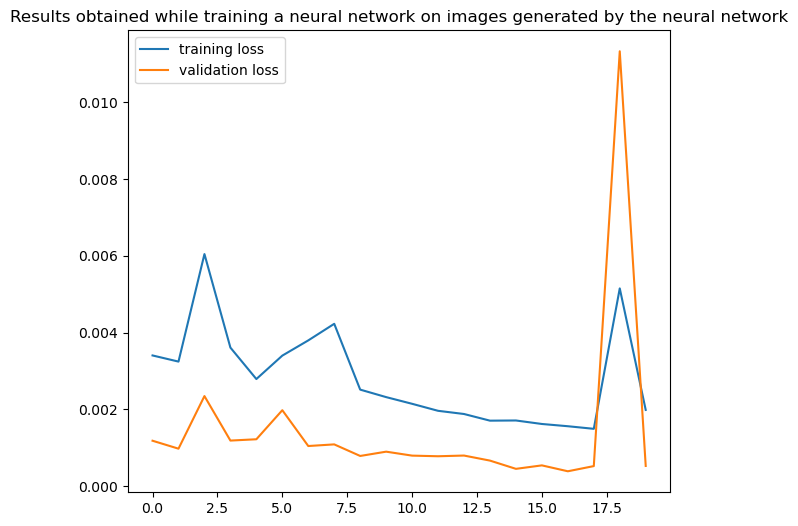

In [170]:
plt.figure(figsize = (7, 6))
plt.plot(newhistory.history['loss'], label = 'training loss')
plt.plot(newhistory.history['val_loss'], label = 'validation loss')
plt.title('Results obtained while training a neural network on images generated by the neural network')
plt.legend()

In [171]:
m.evaluate(newwimages, newwlabels)

326/326 [==============================] - 314s 964ms/step - loss: 0.3126


0.31258517503738403

In [172]:
y_pred = tf.squeeze(m.predict(newwimages))
y_pred.shape

326/326 [==============================] - 262s 803ms/step


TensorShape([10432])

In [173]:
y_pred = y_pred >= 0.5
y_pred = np.array(y_pred, dtype = 'int32')
y_pred

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [174]:
accuracy_score(y_pred, newwlabels)*100

92.43673312883436

In [175]:
print(classification_report(y_pred, newwlabels))

              precision    recall  f1-score   support

           0       0.97      0.78      0.87      3323
           1       0.91      0.99      0.95      7109

    accuracy                           0.92     10432
   macro avg       0.94      0.89      0.91     10432
weighted avg       0.93      0.92      0.92     10432



In [176]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_pred, newwlabels)
cm

array([[2608,  715],
       [  74, 7035]])

In [177]:
print('f1_score: {}, recall_score: {}, precision_score: {}'.format(f1_score(y_pred, newwlabels)*100,
                                                                   recall_score(y_pred, newwlabels)*100,
                                                                   precision_score(y_pred, newwlabels)*100))

f1_score: 94.69008681607106, recall_score: 98.95906597271065, precision_score: 90.77419354838709


In [178]:
import pandas as pd
cmObject = pd.DataFrame(cm , index = ['NORMAL', 'PNEUMONIA'],
                        columns = ['NORMAL', 'PNEUMONIA'])
cmObject.head()

NORMAL  PNEUMONIA
NORMAL       2608        715
PNEUMONIA      74       7035

<Axes: >

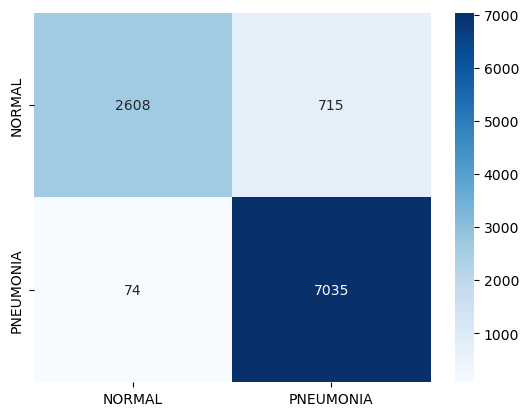

In [179]:
sns.heatmap(cmObject, annot=True, fmt='d', cmap="Blues")

In [180]:
newesthistory = m.fit(imagesGeneration, np.argmax(newlabels, axis = 1),
                epochs = 20, batch_size = 64,
                validation_split = 0.3)

Epoch 1/20
329/329 [==============================] - 2640s 8s/step - loss: 0.0015 - val_loss: 5.4360e-04
Epoch 2/20
329/329 [==============================] - 2659s 8s/step - loss: 0.0014 - val_loss: 4.0807e-04
Epoch 3/20
329/329 [==============================] - 2825s 9s/step - loss: 0.0013 - val_loss: 3.2550e-04
Epoch 4/20
329/329 [==============================] - 3102s 9s/step - loss: 0.0012 - val_loss: 0.2381
Epoch 5/20
329/329 [==============================] - 2591s 8s/step - loss: 0.0080 - val_loss: 0.0019
Epoch 6/20
329/329 [==============================] - 2556s 8s/step - loss: 0.0034 - val_loss: 4.8286e-04
Epoch 7/20
329/329 [==============================] - 2743s 8s/step - loss: 0.0018 - val_loss: 0.0534
Epoch 8/20
329/329 [==============================] - 2596s 8s/step - loss: 0.0014 - val_loss: 2.7455e-04
Epoch 9/20
329/329 [==============================] - 2599s 8s/step - loss: 0.0012 - val_loss: 4.5494e-04
Epoch 10/20
329/329 [==============================] - 251

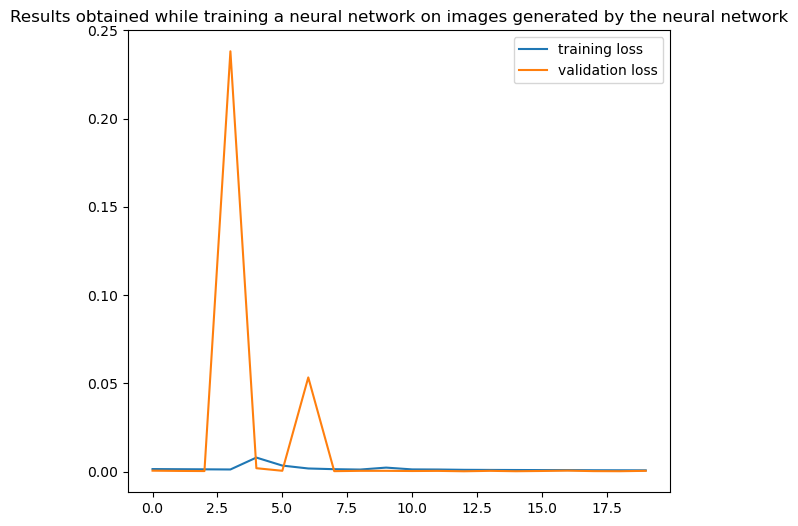

In [181]:
plt.figure(figsize = (7, 6))
plt.plot(newesthistory.history['loss'], label = 'training loss')
plt.plot(newesthistory.history['val_loss'], label = 'validation loss')
plt.title('Results obtained while training a neural network on images generated by the neural network')
plt.legend()

In [182]:
m.evaluate(newwimages, newwlabels)

326/326 [==============================] - 264s 807ms/step - loss: 0.4349


0.4349021315574646

In [183]:
y_predd = tf.squeeze(m.predict(newwimages))
y_predd.shape

326/326 [==============================] - 246s 754ms/step


TensorShape([10432])

In [184]:
y_predd = y_predd >= 0.5
y_predd = np.array(y_predd, dtype = 'int32')
y_predd

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [185]:
accuracy_score(y_predd, newwlabels)*100

91.88075153374233

In [186]:
print(classification_report(y_predd, newwlabels))

              precision    recall  f1-score   support

           0       0.98      0.77      0.86      3435
           1       0.90      0.99      0.94      6997

    accuracy                           0.92     10432
   macro avg       0.94      0.88      0.90     10432
weighted avg       0.92      0.92      0.92     10432



In [187]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_predd, newwlabels)
cm

array([[2635,  800],
       [  47, 6950]])

In [188]:
print('f1_score: {}, recall_score: {}, precision_score: {}'.format(f1_score(y_predd, newwlabels)*100,
                                                                   recall_score(y_predd, newwlabels)*100,
                                                                   precision_score(y_predd, newwlabels)*100))

f1_score: 94.25645894080151, recall_score: 99.3282835500929, precision_score: 89.6774193548387


In [190]:
import pandas as pd
cmObjectt = pd.DataFrame(cm , index = ['NORMAL', 'PNEUMONIA'],
                        columns = ['NORMAL', 'PNEUMONIA'])
cmObjectt.head()

NORMAL  PNEUMONIA
NORMAL       2635        800
PNEUMONIA      47       6950

<Axes: >

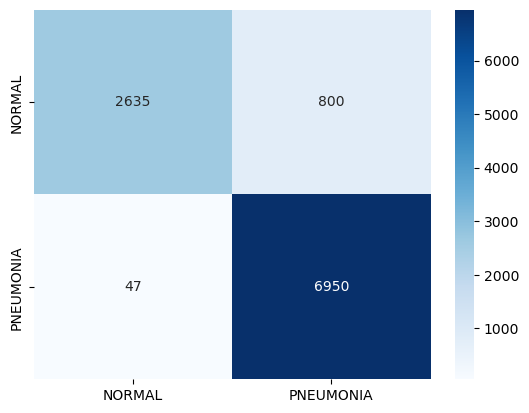

In [191]:
sns.heatmap(cmObjectt, annot=True, fmt='d', cmap="Blues")

In [192]:
m.save('acgan-classifier.keras')